<a href="https://colab.research.google.com/github/hazelhkim/Pytorch/blob/master/Representation_Learning_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [113]:
#from utils import load_mnist
#from trainer import Trainer

In [114]:
from argparse import Namespace 

config = {
    'train_ratio' : .8,
    'batch_size' : 256,
    'n_epochs' : 50,
    'verbose' : 1,
    'btl_size' : 2
} 

config = Namespace(**config)
print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


# Model


In [93]:
import torch.nn as nn

class Autoencoder(nn.Module):
  def __init__(self, btl_size=2):
    self.btl_size = btl_size

    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 500),
        nn.ReLU(),
        nn.BatchNorm1d(500),
        nn.Linear(500, 200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.BatchNorm1d(20),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.BatchNorm1d(10),
        nn.Linear(10, btl_size),
    )

    self.decoder = nn.Sequential(
        nn.Linear(btl_size, 10),
        nn.ReLU(),
        nn.BatchNorm1d(10),
        nn.Linear(10, 20),
        nn.ReLU(),
        nn.BatchNorm1d(20),
        nn.Linear(20, 50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(100, 200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200, 500),
        nn.ReLU(),
        nn.BatchNorm1d(500),
        nn.Linear(500, 28*28),
    )

  def forward(self, x):
    z = self.encoder(x)
    y = self.decoder(z)
    
    return y

# 2. DataLoader

In [115]:
def load_mnist(is_train = True, flatten = True):
  from torchvision import datasets, transforms
  dataset = datasets.MNIST(
      root = '../data', train= is_train, download = True, 
      transform = transforms.Compose([
        transforms.ToTensor(),                                 
      ])
  )
  # filter out x and y
  x = dataset.data.float()/255.
  y = dataset.targets

  # flatten x data
  if flatten:
    x = x.view(x.size(0), -1)

  return x, y

In [116]:
def show_image(x):
  if x.dim() == 1:
    x = x.view(int(x.size(0)**.5), -1)

    plt.imshow(x, cmap='gray')
    plt.show()

In [117]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0)*config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt


# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim = 0,
    index = indices
).split([train_cnt, valid_cnt], dim=0)
train_y, valid_y = torch.index_select(
    train_y,
    dim = 0,
    index = indices
).split([train_cnt, valid_cnt], dim=0)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)


Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [118]:
def _train(model, optimizer, crit, x, y, config):
  # Set the model as a training mode.
  model.train()

  # Shuffle before start.
  indices = torch.randperm(x.size(0), device = x.device)
  x = torch.index_select(x, dim=0, index = indices).split(config.batch_size, dim=0)
  y = torch.index_select(y, dim=0, index = indices).split(config.batch_size, dim=0)

  total_loss = 0

  for i, (x_i, y_i) in enumerate(zip(x, y)):
    y_i_hat = model(x_i)
    loss_i = crit(y_i_hat, y_i.squeeze()) # y_i might have unnecessary extra space other than dim=0.

    # Initialize the graidents of the model.
    optimizer.zero_grad()
    loss_i.backward()
    optimizer.step()

    if config.verbose >= 2:
      print("Train Iteration(%d/%d): loss=%.4e" %(i+1, len(x), float(loss_i)))

    # Don't forget to detach to prevent memory leak.
    total_loss += float(loss_i)

  return total_loss/len(x)


def _validate(model, optimizer, crit, x, y, config):
  # Turn evaluation mode on.
  model.eval()

  # Turn on the no_grad mode to make more efficeint
  with torch.no_grad():
    # Shuffle before begin. 
    indices = torch.randperm(x.size(0), device=x.device)
    x = torch.index_select(x, dim=0, index=indices).split(config.batch_size, dim=0)
    y = torch.index_select(y, dim=0, index=indices).split(config.batch_size, dim=0)
    
    total_loss = 0

    for i, (x_i, y_i) in enumerate(zip(x, y)):
      y_hat_i = model(x_i)
      loss_i = crit(y_hat_i, y_i.squeeze())

      if config.verbose >= 2:
        print("Valid Iteration (%d/%d): loss=%.4e" %(i+1, len(x), float(loss_i)))

      total_loss += float(loss_i)

    return total_loss/len(x)


def train(model, optimizer, crit, train_data, valid_data, config):
  lowest_loss = np.inf
  best_model = None

  for epoch_index in range(config.n_epochs):
    train_loss = _train(model, optimizer, crit, train_data[0], train_data[1], config)
    valid_loss = _validate(model, optimizer, crit, valid_data[0], valid_data[1], config)

    # You must use deep copy to take a snapshot of current best weights.
    if valid_loss <= lowest_loss:
      lowest_loss = valid_loss
      best_model = deepcopy(model.state_dict())

    print("Epoch(%d/%d): train_loss = %.4e  valid_loss = %.4e  lowest_loss = %.4e" %(
        epoch_index + 1, 
        config.n_epochs,
        train_loss,
        valid_loss,
        lowest_loss,
    ))

    # Restore to best model.
    model.load_state_dict(best_model)

In [119]:
print(len(train_x[0]))

784


In [120]:
model = Autoencoder(btl_size = config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

train(model, optimizer, crit, (train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss = 7.4417e-02  valid_loss = 5.1099e-02  lowest_loss = 5.1099e-02
Epoch(2/50): train_loss = 4.8612e-02  valid_loss = 4.5734e-02  lowest_loss = 4.5734e-02
Epoch(3/50): train_loss = 4.5221e-02  valid_loss = 4.3872e-02  lowest_loss = 4.3872e-02
Epoch(4/50): train_loss = 4.3897e-02  valid_loss = 4.2292e-02  lowest_loss = 4.2292e-02
Epoch(5/50): train_loss = 4.2843e-02  valid_loss = 4.1535e-02  lowest_loss = 4.1535e-02
Epoch(6/50): train_loss = 4.2165e-02  valid_loss = 4.0656e-02  lowest_loss = 4.0656e-02
Epoch(7/50): train_loss = 4.1488e-02  valid_loss = 4.0317e-02  lowest_loss = 4.0317e-02
Epoch(8/50): train_loss = 4.1334e-02  valid_loss = 4.0048e-02  lowest_loss = 4.0048e-02
Epoch(9/50): train_loss = 4.0650e-02  valid_loss = 3.9980e-02  lowest_loss = 3.9980e-02
Epoch(10/50): train_loss = 4.0482e-02  valid_loss = 4.0245e-02  lowest_loss = 3.9980e-02
Epoch(11/50): train_loss = 4.0676e-02  valid_loss = 3.9302e-02  lowest_loss = 3.9302e-02
Epoch(12/50): train_loss = 4.0

# Test

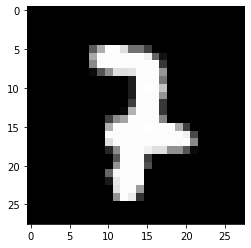

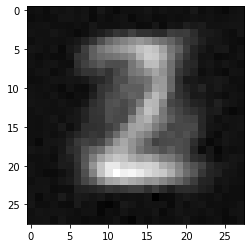

In [121]:
with torch.no_grad():
  import random
  index = int(random.random() * test_x.size(0))
  recon = model(test_x[index].view(1,-1)).squeeze()

  show_image(test_x[index])
  show_image(recon)

# Latent Space

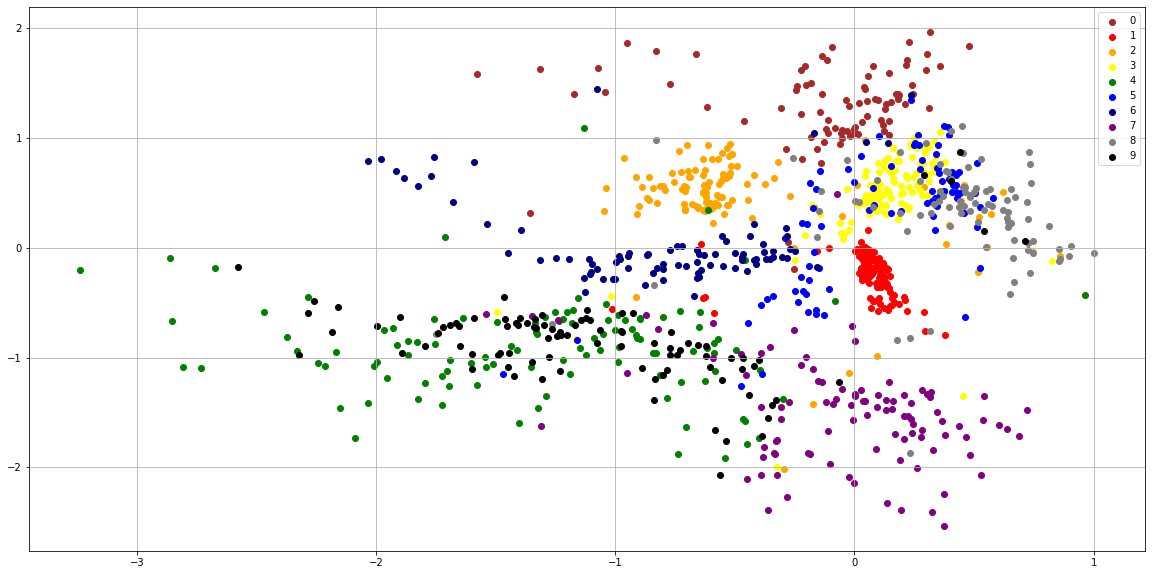

In [122]:
if config.btl_size == 2:
  color_map = [
      'brown', 'red', 'orange', 'yellow', 'green', 
      'blue', 'navy', 'purple', 'gray', 'black',
  ]

  plt.figure(figsize=(20,10))
  with torch.no_grad():
    latents = model.encoder(test_x[:1000])

    for i in range(10):
      target_latents = latents[test_y[:1000]==i]
      target_y = test_y[:1000][test_y[:1000]==i]
      plt.scatter(target_latents[:,0],
                  target_latents[:,1],
                  marker = 'o',
                  color = color_map[i],
                  label=i)
    plt.legend()
    plt.grid(axis='both')
    plt.show()

In [128]:
if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range, step)]),
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            lines += [line]
            
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)

<Figure size 1440x1440 with 0 Axes>